In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os

sys.path.append(os.path.abspath('..'))
from utils.custom_transformers import FeatureCombiner

In [3]:
# Load the tuned model
with open('../models/best_model_random_forest_tuned.pkl', 'rb') as f:
    model_data = pickle.load(f)

model = model_data['model']
label_encoder = model_data['label_encoder']
label_mapping = model_data['label_mapping']
print(f"✅ Model loaded: Random Forest")
print(f"✅ Label encoder loaded")

✅ Model loaded: Random Forest
✅ Label encoder loaded


In [4]:
# Load preprocessed data
data = pd.read_csv('../data/bugs_preprocessed.csv')

In [5]:
# Drop empty text
data = data[
    data['text_processed'].notna() & 
    (data['text_processed'].str.strip() != '')
].copy()
data = data.reset_index(drop=True)

In [6]:
# Add text length
data['text_length'] = data['text_processed'].str.split().str.len()

print(f"✅ Data loaded: {len(data)} samples")

✅ Data loaded: 9997 samples


In [7]:
# Prepare features
from sklearn.model_selection import train_test_split

# Prepare features
from sklearn.model_selection import train_test_split

X_combined_data = pd.DataFrame({
    'text_processed': data['text_processed'],
    'component_name': data['component_name'],
    'product_name': data['product_name'],
    'text_length': data['text_length']
})
y_original = data['severity_category']
y_encoded = label_encoder.transform(y_original)

# Same split as training
X_dev, X_test, y_dev, y_test = train_test_split(
    X_combined_data, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

# Get predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Decode back to labels
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print(f"✅ Predictions generated")

✅ Predictions generated


In [8]:
# Feature Importance Analysis
# Extract components from pipeline
feature_combiner = model.named_steps['feature_combiner']
classifier = model.named_steps['classifier']

# Get feature names
tfidf_features = list(feature_combiner.tfidf.get_feature_names_out())
categorical_features = ['component', 'product', 'text_length']
all_feature_names = tfidf_features + categorical_features

# Get feature importances
feature_importances = classifier.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

In [9]:
# Visualization 1: Top 30 Features
print("\nTop 30 Most Important Features:")
print(f"{'Rank':<6} {'Feature':<40} {'Importance':<12} {'Type':<15}")
print("-"*70)

for rank, (idx, row) in enumerate(importance_df.head(30).iterrows(), 1):
    feature = row['feature']
    importance = row['importance']

    if feature in categorical_features:
        feat_type = "Categorical/Numeric"
    else:
        feat_type = "Text (TF-IDF)"
    
    print(f"{rank:<6} {feature:<40} {importance:<12.6f} {feat_type:<15}")


Top 30 Most Important Features:
Rank   Feature                                  Importance   Type           
----------------------------------------------------------------------
1      crash                                    0.069876     Text (TF-IDF)  
2      component                                0.018634     Categorical/Numeric
3      product                                  0.018311     Categorical/Numeric
4      text_length                              0.014351     Categorical/Numeric
5      identifier                               0.012050     Text (TF-IDF)  
6      useragent                                0.011538     Text (TF-IDF)  
7      work                                     0.011529     Text (TF-IDF)  
8      release                                  0.011177     Text (TF-IDF)  
9      error                                    0.009361     Text (TF-IDF)  
10     stack                                    0.009206     Text (TF-IDF)  
11     talkback                      


✅ Feature importance plot saved: ../figures/feature_importance_detailed.png


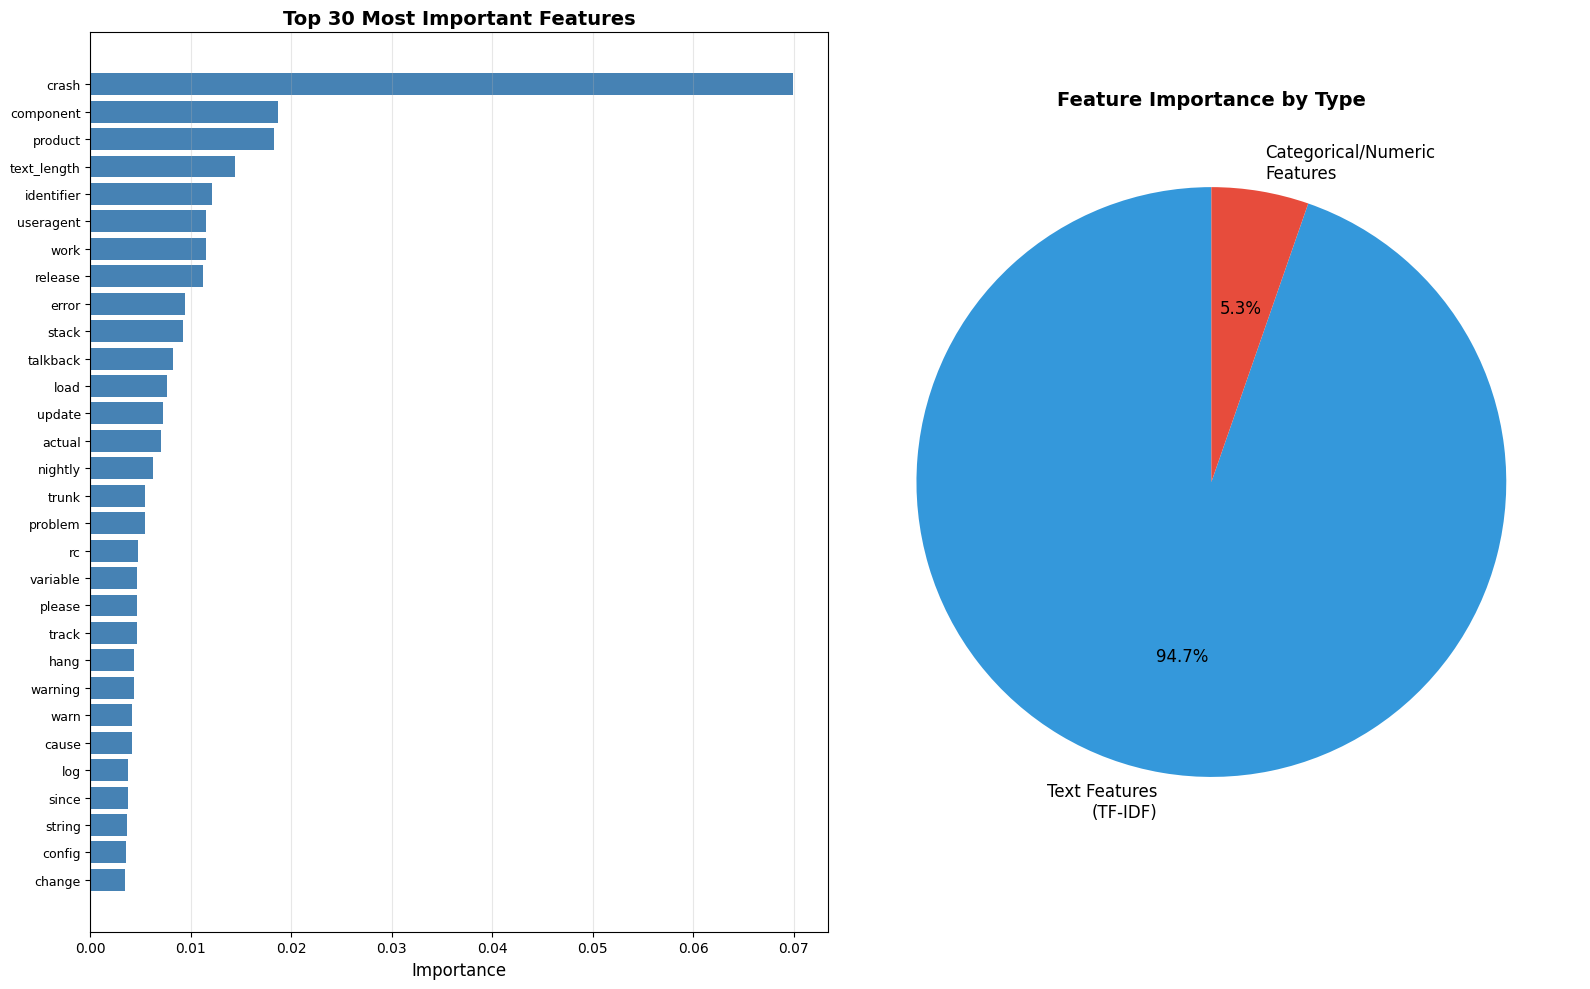

In [10]:
# Plot the top 30
fig, axes = plt.subplots(1, 2, figsize=(16,10))

# Top 30 overall
top_30 = importance_df.head(30)
axes[0].barh(range(len(top_30)), top_30['importance'].values, color='steelblue')
axes[0].set_yticks(range(len(top_30)))
axes[0].set_yticklabels(top_30['feature'].values, fontsize=9)
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Top 30 Most Important Features', fontweight='bold', fontsize=14)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Feature type breakdown
text_importance = importance_df[~importance_df['feature'].isin(categorical_features)]['importance'].sum()
cat_importance = importance_df[importance_df['feature'].isin(categorical_features)]['importance'].sum()

feature_types = ['Text Features\n(TF-IDF)', 'Categorical/Numeric\nFeatures']
type_importance = [text_importance, cat_importance]
colors = ['#3498db', '#e74c3c']

axes[1].pie(type_importance, labels=feature_types, autopct='%1.1f%%', 
            startangle=90, colors=colors, textprops={'fontsize': 12})
axes[1].set_title('Feature Importance by Type', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('../figures/feature_importance_detailed.png', dpi=300, bbox_inches='tight')
print("\n✅ Feature importance plot saved: ../figures/feature_importance_detailed.png")
plt.show()

In [11]:
# Top text features
# Feature importance insights
top_text_features = importance_df[~importance_df['feature'].isin(categorical_features)].head(10)
print("\nTop 10 Text Features (words/phrases):")
for idx, row in top_text_features.iterrows():
    print(f"  • {row['feature']}: {row['importance']:.6f}")

# Categorical feature importance
cat_features = importance_df[importance_df['feature'].isin(categorical_features)]
print("\nCategorical/Numeric Feature Importance:")
for idx, row in cat_features.iterrows():
    print(f"  • {row['feature']}: {row['importance']:.6f}")

# Calculate percentage
text_pct = (text_importance / (text_importance + cat_importance)) * 100
cat_pct = (cat_importance / (text_importance + cat_importance)) * 100

print(f"\nOverall contribution:")
print(f"  Text features: {text_pct:.1f}%")
print(f"  Categorical/Numeric features: {cat_pct:.1f}%")


Top 10 Text Features (words/phrases):
  • crash: 0.069876
  • identifier: 0.012050
  • useragent: 0.011538
  • work: 0.011529
  • release: 0.011177
  • error: 0.009361
  • stack: 0.009206
  • talkback: 0.008238
  • load: 0.007576
  • update: 0.007192

Categorical/Numeric Feature Importance:
  • component: 0.018634
  • product: 0.018311
  • text_length: 0.014351
  • component: 0.001026
  • product: 0.000944

Overall contribution:
  Text features: 94.7%
  Categorical/Numeric features: 5.3%


In [12]:
# Error Analysis
# Create error analysis DataFrame
test_df = X_test.copy()
test_df['true_label'] = y_test_labels
test_df['predicted_label'] = y_pred_labels
test_df['is_correct'] = (y_test_labels == y_pred_labels)
test_df['confidence'] = y_pred_proba.max(axis=1)

# Add original data
test_indices = X_test.index
test_df['short_description'] = data.loc[test_indices, 'short_description'].values
test_df['long_description'] = data.loc[test_indices, 'long_description'].values

In [13]:
print("\n1. Overall Error Statistics:")
print("-"*70)

total_errors = (~test_df['is_correct']).sum()
total_samples = len(test_df)
error_rate = (total_errors / total_samples) * 100

print(f"Total predictions: {total_samples}")
print(f"Correct predictions: {total_samples - total_errors} ({100-error_rate:.1f}%)")
print(f"Incorrect predictions: {total_errors} ({error_rate:.1f}%)")


1. Overall Error Statistics:
----------------------------------------------------------------------
Total predictions: 2000
Correct predictions: 1334 (66.7%)
Incorrect predictions: 666 (33.3%)


In [14]:
print("\n2. Error Analysis by True Class:")
print("-"*70)

error_by_class = []
for true_class in sorted(label_encoder.classes_):
    class_mask = test_df['true_label'] == true_class
    class_total = class_mask.sum()
    class_errors = (~test_df[class_mask]['is_correct']).sum()
    class_error_rate = (class_errors / class_total * 100) if class_total > 0 else 0
    
    error_by_class.append({
        'Class': true_class,
        'Total': class_total,
        'Errors': class_errors,
        'Error Rate (%)': class_error_rate,
        'Accuracy (%)': 100 - class_error_rate
    })

error_by_class_df = pd.DataFrame(error_by_class)
print(error_by_class_df.to_string(index=False))


2. Error Analysis by True Class:
----------------------------------------------------------------------
   Class  Total  Errors  Error Rate (%)  Accuracy (%)
 blocker     41      38       92.682927      7.317073
critical    121      61       50.413223     49.586777
   major    148     124       83.783784     16.216216
   minor    108     103       95.370370      4.629630
  normal   1521     291       19.132150     80.867850
 trivial     61      49       80.327869     19.672131


In [15]:
print("\n3. Most Common Misclassification Patterns:")
print("-"*70)

# Find misclassification patterns
misclassified = test_df[~test_df['is_correct']]
confusion_patterns = misclassified.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
confusion_patterns = confusion_patterns.sort_values('count', ascending=False)

print(f"\nTop 10 confusion patterns:")
print(f"{'True Label':<15} {'Predicted As':<15} {'Count':<10} {'% of Errors':<15}")
print("-"*70)

for idx, row in confusion_patterns.head(10).iterrows():
    pct = (row['count'] / total_errors) * 100
    print(f"{row['true_label']:<15} {row['predicted_label']:<15} {row['count']:<10} {pct:<15.1f}%")



3. Most Common Misclassification Patterns:
----------------------------------------------------------------------

Top 10 confusion patterns:
True Label      Predicted As    Count      % of Errors    
----------------------------------------------------------------------
normal          major           126        18.9           %
major           normal          97         14.6           %
minor           normal          75         11.3           %
normal          trivial         65         9.8            %
normal          minor           50         7.5            %
critical        normal          48         7.2            %
normal          critical        46         6.9            %
trivial         normal          34         5.1            %
blocker         normal          28         4.2            %
minor           major           16         2.4            %


In [16]:
print("\n4. Prediction Confidence Analysis:")
print("-"*70)

correct_confidence = test_df[test_df['is_correct']]['confidence'].mean()
incorrect_confidence = test_df[~test_df['is_correct']]['confidence'].mean()

print(f"Average confidence (correct predictions): {correct_confidence:.3f}")
print(f"Average confidence (incorrect predictions): {incorrect_confidence:.3f}")
print(f"Confidence gap: {correct_confidence - incorrect_confidence:.3f}")

# Low confidence errors
low_conf_threshold = 0.5
low_conf_errors = misclassified[misclassified['confidence'] < low_conf_threshold]
print(f"\nLow-confidence errors (<{low_conf_threshold}): {len(low_conf_errors)} ({len(low_conf_errors)/total_errors*100:.1f}% of errors)")

# High confidence errors (more problematic!)
high_conf_threshold = 0.7
high_conf_errors = misclassified[misclassified['confidence'] >= high_conf_threshold]
print(f"High-confidence errors (≥{high_conf_threshold}): {len(high_conf_errors)} ({len(high_conf_errors)/total_errors*100:.1f}% of errors)")


4. Prediction Confidence Analysis:
----------------------------------------------------------------------
Average confidence (correct predictions): 0.346
Average confidence (incorrect predictions): 0.312
Confidence gap: 0.034

Low-confidence errors (<0.5): 659 (98.9% of errors)
High-confidence errors (≥0.7): 1 (0.2% of errors)



✅ Error analysis plots saved: ../figures/error_analysis_overview.png


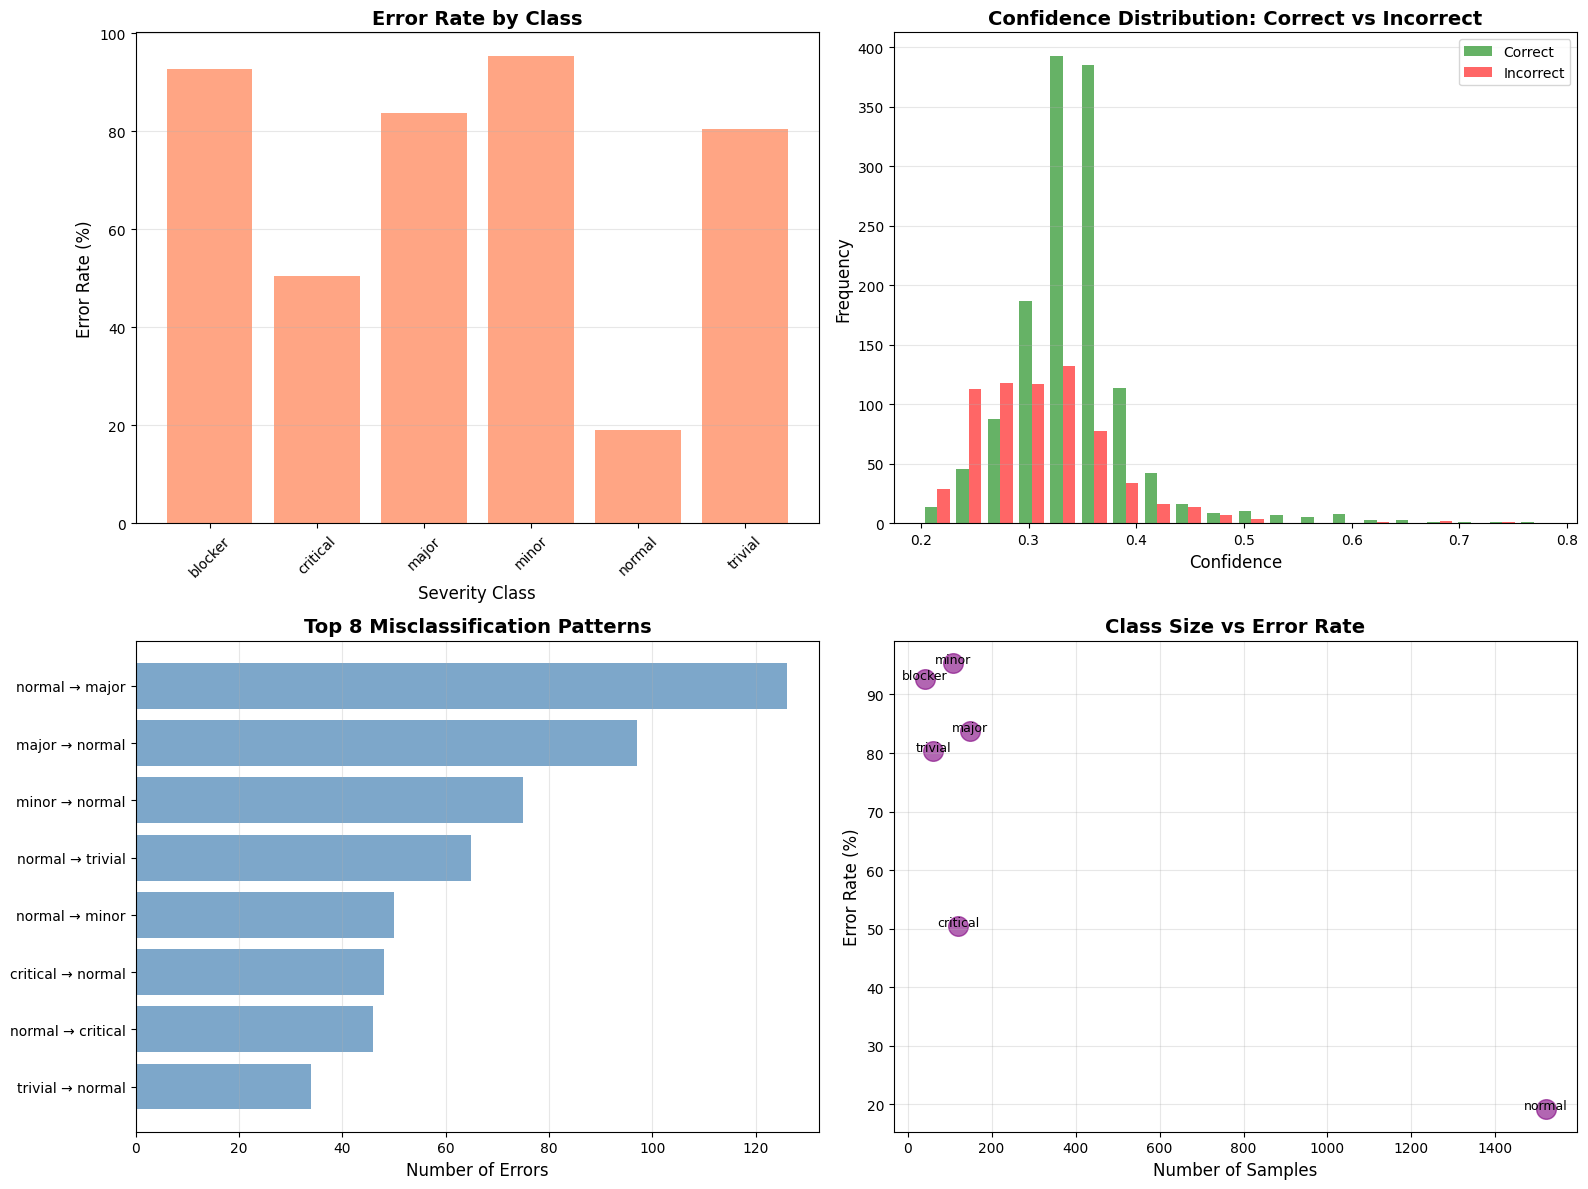

In [17]:
# Visualization 2: Error Analysis Plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Error rate by class
axes[0, 0].bar(error_by_class_df['Class'], error_by_class_df['Error Rate (%)'], 
               color='coral', alpha=0.7)
axes[0, 0].set_xlabel('Severity Class', fontsize=12)
axes[0, 0].set_ylabel('Error Rate (%)', fontsize=12)
axes[0, 0].set_title('Error Rate by Class', fontweight='bold', fontsize=14)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Confidence distribution
axes[0, 1].hist([test_df[test_df['is_correct']]['confidence'],
                 test_df[~test_df['is_correct']]['confidence']],
                bins=20, label=['Correct', 'Incorrect'], 
                color=['green', 'red'], alpha=0.6)
axes[0, 1].set_xlabel('Confidence', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Confidence Distribution: Correct vs Incorrect', 
                      fontweight='bold', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Top confusion patterns
top_confusions = confusion_patterns.head(8)
confusion_labels = [f"{row['true_label']} → {row['predicted_label']}" 
                   for _, row in top_confusions.iterrows()]
axes[1, 0].barh(range(len(top_confusions)), top_confusions['count'].values, 
                color='steelblue', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_confusions)))
axes[1, 0].set_yticklabels(confusion_labels, fontsize=10)
axes[1, 0].set_xlabel('Number of Errors', fontsize=12)
axes[1, 0].set_title('Top 8 Misclassification Patterns', fontweight='bold', fontsize=14)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Plot 4: Sample size vs error rate
axes[1, 1].scatter(error_by_class_df['Total'], error_by_class_df['Error Rate (%)'],
                   s=200, alpha=0.6, color='purple')
for idx, row in error_by_class_df.iterrows():
    axes[1, 1].annotate(row['Class'], 
                        (row['Total'], row['Error Rate (%)']),
                        fontsize=9, ha='center')
axes[1, 1].set_xlabel('Number of Samples', fontsize=12)
axes[1, 1].set_ylabel('Error Rate (%)', fontsize=12)
axes[1, 1].set_title('Class Size vs Error Rate', fontweight='bold', fontsize=14)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/error_analysis_overview.png', dpi=300, bbox_inches='tight')
print("\n✅ Error analysis plots saved: ../figures/error_analysis_overview.png")
plt.show()

In [18]:
print("\n5. Critical Misclassification Examples:")
print("-"*70)

# Most critical: Missing blocker/critical bugs
critical_missed = misclassified[
    (misclassified['true_label'].isin(['blocker', 'critical'])) &
    (misclassified['predicted_label'] == 'normal')
]

print(f"\nCritical/Blocker bugs misclassified as Normal: {len(critical_missed)}")

if len(critical_missed) > 0:
    print("\nExample cases:")
    for idx, row in critical_missed.head(3).iterrows():
        print(f"\n  Case {idx}:")
        print(f"  True: {row['true_label']} | Predicted: {row['predicted_label']} | Confidence: {row['confidence']:.2f}")
        print(f"  Description: {row['short_description'][:100]}...")
        print(f"  Text length: {row['text_length']} words")

# False alarms: Normal predicted as critical
false_alarms = misclassified[
    (misclassified['true_label'] == 'normal') &
    (misclassified['predicted_label'].isin(['blocker', 'critical']))
]

print(f"\n\nNormal bugs misclassified as Critical/Blocker: {len(false_alarms)}")

if len(false_alarms) > 0:
    print("\nExample cases:")
    for idx, row in false_alarms.head(3).iterrows():
        print(f"\n  Case {idx}:")
        print(f"  True: {row['true_label']} | Predicted: {row['predicted_label']} | Confidence: {row['confidence']:.2f}")
        print(f"  Description: {row['short_description'][:100]}...")
        print(f"  Text length: {row['text_length']} words")


5. Critical Misclassification Examples:
----------------------------------------------------------------------

Critical/Blocker bugs misclassified as Normal: 76

Example cases:

  Case 2612:
  True: critical | Predicted: normal | Confidence: 0.25
  Description: threading by subject slow when threads are large...
  Text length: 58 words

  Case 2358:
  True: critical | Predicted: normal | Confidence: 0.32
  Description: Some files not tagged in FIREFOX_1_0_7_RELEASE...
  Text length: 15 words

  Case 9822:
  True: critical | Predicted: normal | Confidence: 0.30
  Description: Running a mass change clears group bits....
  Text length: 16 words


Normal bugs misclassified as Critical/Blocker: 50

Example cases:

  Case 7800:
  True: normal | Predicted: critical | Confidence: 0.37
  Description: Unsuitable behaviour when $HOME is not set...
  Text length: 56 words

  Case 4548:
  True: normal | Predicted: critical | Confidence: 0.34
  Description: Reduce the search to version only when b

In [19]:
print("\n6. Text Length vs Error Rate:")
print("-"*70)

# Bin text lengths
test_df['text_length_bin'] = pd.cut(test_df['text_length'], 
                                     bins=[0, 20, 50, 100, 200, 1000],
                                     labels=['Very Short (0-20)', 'Short (20-50)', 
                                            'Medium (50-100)', 'Long (100-200)', 
                                            'Very Long (200+)'])

length_error = test_df.groupby('text_length_bin').agg({
    'is_correct': ['count', lambda x: (~x).sum(), 'mean']
}).round(3)

length_error.columns = ['Total', 'Errors', 'Accuracy']
length_error['Error Rate (%)'] = (1 - length_error['Accuracy']) * 100
length_error['Accuracy (%)'] = length_error['Accuracy'] * 100

print(length_error[['Total', 'Errors', 'Error Rate (%)', 'Accuracy (%)']].to_string())


6. Text Length vs Error Rate:
----------------------------------------------------------------------
                   Total  Errors  Error Rate (%)  Accuracy (%)
text_length_bin                                               
Very Short (0-20)    612     130            21.2          78.8
Short (20-50)        836     275            32.9          67.1
Medium (50-100)      413     195            47.2          52.8
Long (100-200)       120      58            48.3          51.7
Very Long (200+)      19       8            42.1          57.9


In [20]:
print("\n" + "="*70)
print("SAVING ERROR ANALYSIS REPORT")
print("="*70)

import os
os.makedirs('../results', exist_ok=True)

report_filename = '../results/error_analysis_report.txt'
with open(report_filename, 'w') as f:
    f.write("="*70 + "\n")
    f.write("ERROR ANALYSIS REPORT\n")
    f.write("Bug Severity Classification - Random Forest Model\n")
    f.write("="*70 + "\n\n")
    
    f.write("1. OVERALL STATISTICS\n")
    f.write("-"*70 + "\n")
    f.write(f"Total predictions: {total_samples}\n")
    f.write(f"Correct: {total_samples - total_errors} ({100-error_rate:.1f}%)\n")
    f.write(f"Incorrect: {total_errors} ({error_rate:.1f}%)\n\n")
    
    f.write("2. ERROR RATE BY CLASS\n")
    f.write("-"*70 + "\n")
    f.write(error_by_class_df.to_string(index=False) + "\n\n")
    
    f.write("3. TOP MISCLASSIFICATION PATTERNS\n")
    f.write("-"*70 + "\n")
    f.write(confusion_patterns.head(10).to_string(index=False) + "\n\n")
    
    f.write("4. CONFIDENCE ANALYSIS\n")
    f.write("-"*70 + "\n")
    f.write(f"Avg confidence (correct): {correct_confidence:.3f}\n")
    f.write(f"Avg confidence (incorrect): {incorrect_confidence:.3f}\n")
    f.write(f"Confidence gap: {correct_confidence - incorrect_confidence:.3f}\n\n")
    
    f.write("5. CRITICAL ERRORS\n")
    f.write("-"*70 + "\n")
    f.write(f"Critical/Blocker missed (predicted as normal): {len(critical_missed)}\n")
    f.write(f"False alarms (normal predicted as critical): {len(false_alarms)}\n\n")
    
    f.write("6. TEXT LENGTH ANALYSIS\n")
    f.write("-"*70 + "\n")
    f.write(length_error[['Total', 'Errors', 'Error Rate (%)']].to_string() + "\n\n")

print(f"✅ Error analysis report saved: {report_filename}")

# Save detailed error cases to CSV
error_cases_filename = '../results/misclassified_cases.csv'
misclassified[['true_label', 'predicted_label', 'confidence', 'text_length', 
               'short_description', 'component_name', 'product_name']].to_csv(
    error_cases_filename, index=False
)
print(f"✅ Misclassified cases saved: {error_cases_filename}")

print("\n" + "="*70)
print("✅ FEATURE IMPORTANCE & ERROR ANALYSIS COMPLETE!")
print("="*70)

print("\n📊 Generated outputs:")
print("  1. ../figures/feature_importance_detailed.png")
print("  2. ../figures/error_analysis_overview.png")
print("  3. ../results/error_analysis_report.txt")
print("  4. ../results/misclassified_cases.csv")


SAVING ERROR ANALYSIS REPORT
✅ Error analysis report saved: ../results/error_analysis_report.txt
✅ Misclassified cases saved: ../results/misclassified_cases.csv

✅ FEATURE IMPORTANCE & ERROR ANALYSIS COMPLETE!

📊 Generated outputs:
  1. ../figures/feature_importance_detailed.png
  2. ../figures/error_analysis_overview.png
  3. ../results/error_analysis_report.txt
  4. ../results/misclassified_cases.csv
